In [6]:
from hossam import load_data
from scipy.stats import t, ttest_1samp, normaltest, bartlett, levene, ttest_ind, ttest_rel, mannwhitneyu
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt
from pandas import melt, DataFrame
from statannotations.Annotator import Annotator
import numpy as np

In [2]:
my_dpi=200
font_path='../NotoSansKR-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop=fm.FontProperties(fname=font_path)
font_name=font_prop.get_name()
plt.rcParams['font.family']=font_name
plt.rcParams['font.size']=6
plt.rcParams['axes.unicode_minus']=False

In [3]:
origin=load_data('deer')
print('\n===== 데이터 크기 확인 =====')
print(f'데이터셋 크기 : {origin.shape}')
print(f'행 개수 : {origin.shape[0]}개')
print(f'열 개수 : {origin.shape[1]}개')
print('\n===== 타입 확인 =====')
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab10_/deer.xlsx
[desc] 사슴의 왼쪽 앞다리와 왼쪽 뒷다리의 길이를 측정한 자료 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기 : (10, 3)
행 개수 : 10개
열 개수 : 3개

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   사슴      10 non-null     int64
 1   앞다리     10 non-null     int64
 2   뒷다리     10 non-null     int64
dtypes: int64(3)
memory usage: 372.0 bytes
None


,사슴,앞다리,뒷다리
0,1,138,142
1,2,136,140
2,3,147,144
3,4,139,144
4,5,143,142


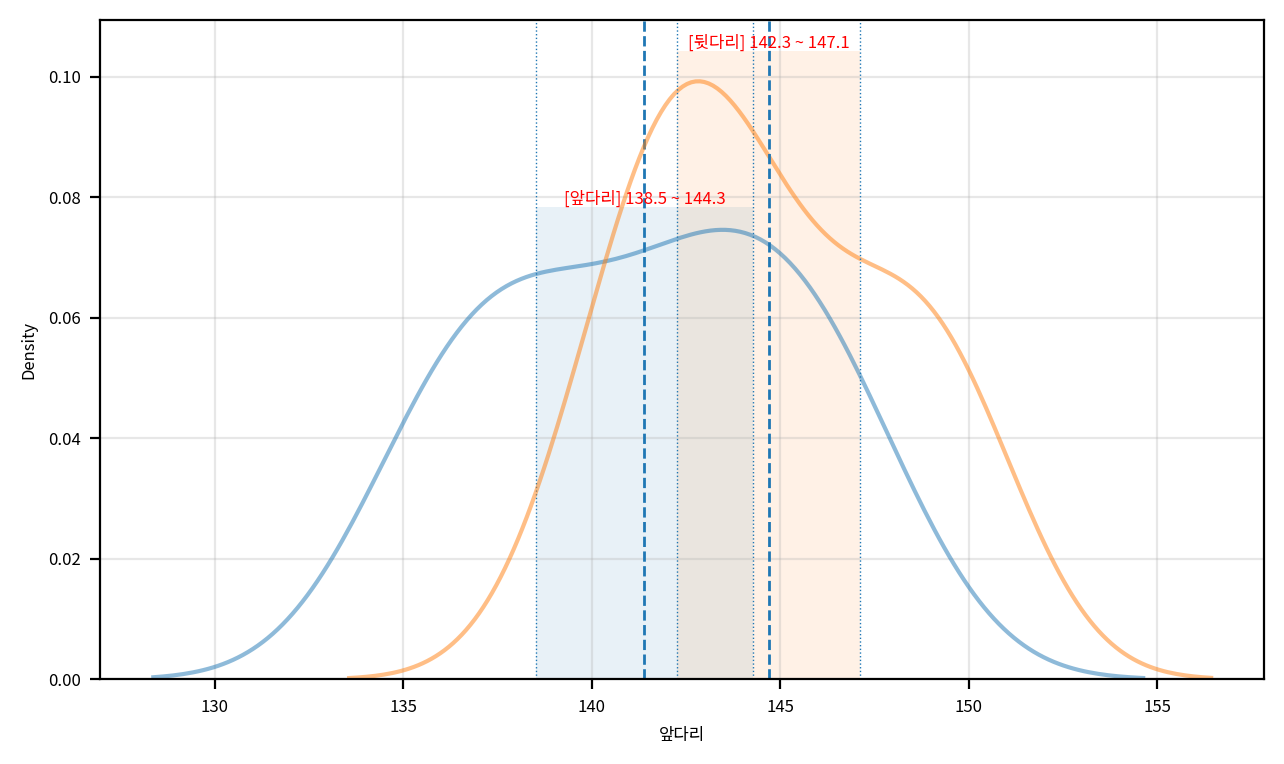

In [4]:
# 확인할 데이터
data=origin[['앞다리','뒷다리']]

width_px=1280
height_px=760
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for c in data.columns:
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    # 신뢰구간
    max=data[c].max()
    clevel=0.95
    dof=len(data[c])-1
    sp_mean=data[c].mean()
    sp_std=data[c].std(ddof=1)
    sp_std_error=sp_std/sqrt(len(data[c]))
    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)

    # 평균 표시
    ymin, ymax=ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기
    ax.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s='[%s] %0.1f ~ %0.1f'%(c, cmin, cmax),
            horizontalalignment='center',
            verticalalignment='bottom',
            fontdict={'size':6, 'color':'red'})

ax.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('myplot.png',dpi=my_dpi)
plt.show()
plt.close()

In [5]:
data=origin[['앞다리','뒷다리']]

equal_var_fields=[]
normal_dist=True
report=[]

for c in data.columns:
    s, p=normaltest(data[c])

    normalize=(p>0.05)
    report.append({
        'field':c,
        'statistic':s,
        'p-value':p,
        'result':normalize
    })
    normal_dist=normal_dist and normalize

if len(data.columns)>1:
    if normal_dist:
        n='Bartlett'
        s, p=bartlett(*data.values.T)
    else:
        n='Levene'
        s, p=levene(*data.values.T, center='median')

    report.append({
        'field':n,
        'statistic':s,
        'p-value':p,
        'result':p>0.05
    })

report_df=DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
앞다리,1.824001,0.401720,True
뒷다리,1.376960,0.502339,True
Bartlett,0.340678,0.559438,True


In [8]:
# 검정할 데이터 필드명
fields=['앞다리','뒷다리']

# 로그 적용 여부
use_log=False

# 검정할 데이터
df=origin[fields]

# 검사할 알고리즘
alternative=['two-sided', 'less', 'greater']

# 결과를 저장할 빈 리스트
result=[]

# 가설식 템플릿
fmt='μ({f0}) {0} μ({f1})'

# 등분산성 충족 여부
equal_var=True

for a in alternative:
    if use_log:
        input1=np.log(df[fields[0]])
        input2=np.log(df[fields[1]])
    else:
        input1=df[fields[0]]
        input2=df[fields[1]]
    s, p=ttest_rel(input1, input2, alternative=a)

    itp=None

    if a=='two-sided':
        itp=fmt.format('==' if p>0.05 else '≠', f0=fields[0], f1=fields[1])
    if a=='less':
        itp=fmt.format('>=' if p>0.05 else '<', f0=fields[0], f1=fields[1])
    if a=='greater':
        itp=fmt.format('<=' if p>0.05 else '>', f0=fields[0], f1=fields[1])

    result.append({
        'alternative':a,
        'statistic':s,
        'p-value':p,
        'H0':p>0.05,
        'H1':p<=0.05,
        'interpretation':itp
    })

    if a=='two-sided' and p>0.05:
        break

rdf=DataFrame(result)
rdf.set_index('alternative', inplace=True)
rdf

,statistic,p-value,H0,H1,interpretation
alternative,,,,,
two-sided,-3.413793,0.007703,False,True,μ(앞다리) ≠ μ(뒷다리)
less,-3.413793,0.003852,False,True,μ(앞다리) < μ(뒷다리)
greater,-3.413793,0.996148,True,False,μ(앞다리) <= μ(뒷다리)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

앞다리 vs. 뒷다리: t-test paired samples, P_val:7.703e-03 t=-3.414e+00


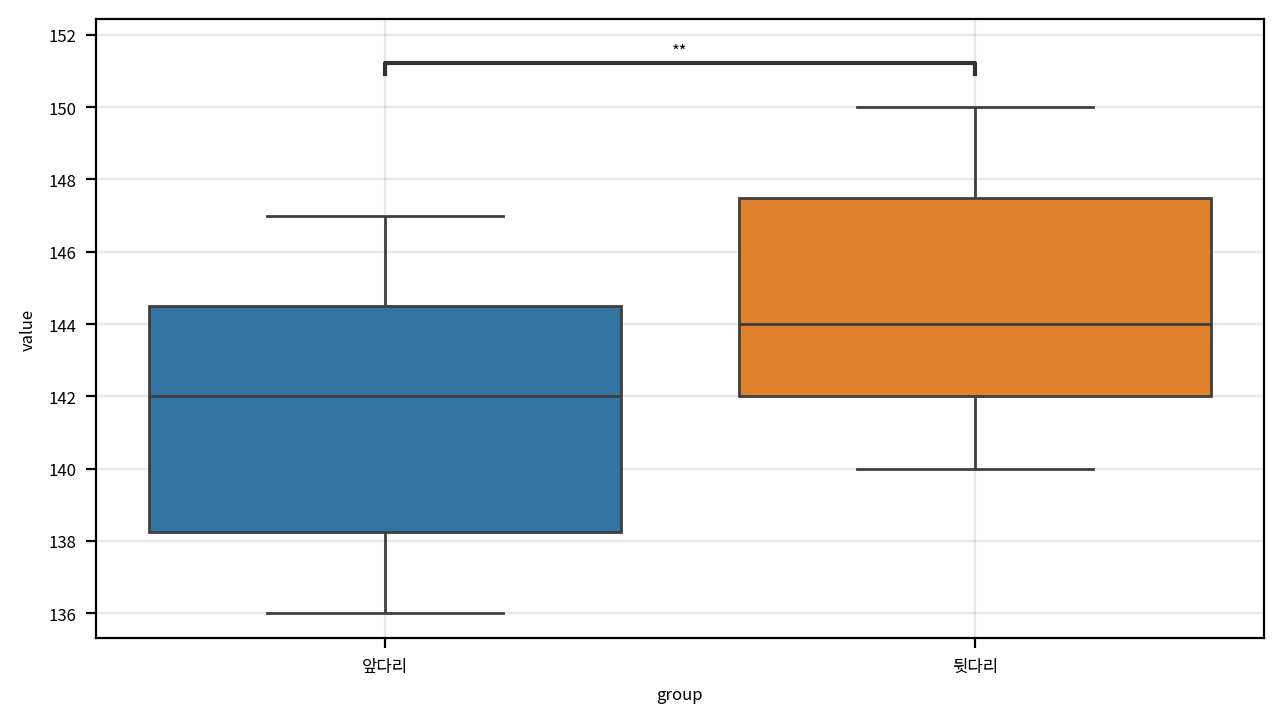

In [9]:
# 검정할 데이터 필드명
fields=['앞다리','뒷다리']

# 검정 방법
# 't-test_ind', 't-test_paired', 't-test_welch', 'Mann-Whitney', 'Mann-Whitney-gt', 'Mann-Whitney-ls', 'Levene', 'Wilcoxon', 'Kruskal'
test_method='t-test_paired'

# 데이터 재배치
df=melt(origin[fields], value_vars=fields, var_name='group', value_name='value')

# 1. 그래프 초기화
width_px=1280
height_px=720
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2. 그래프 그리기
sb.boxplot(data=df, x='group', y='value', hue='group')
annotator=Annotator(ax, data=df, x='group', y='value', pairs=[fields])
annotator.configure(test=test_method)
annotator.apply_and_annotate()

# 3. 그래프 꾸미기
ax.grid(True, alpha=0.3)

# 4. 출력
plt.tight_layout()
# plt.savefig('myplot.png',dpi=my_dpi)
plt.show()
plt.close()

In [10]:
origin=load_data('oil')
print('\n===== 데이터 크기 확인 =====')
print(f'데이터셋 크기 : {origin.shape}')
print(f'행 개수 : {origin.shape[0]}개')
print(f'열 개수 : {origin.shape[1]}개')
print('\n===== 타입 확인 =====')
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab10_/oil.xlsx
[desc] 다섯 종류의 새 차에 대하여 같은 종류의 차 두 대 중에서 한 대를 랜덤하게 선택하여 첨가제를 사용하고, 다른 한 대에는 첨가제를 사용하지 않고 같은 운전자가 같은 장소에서 운전한 후 주행거리를 측정한 결과 데이터 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기 : (10, 2)
행 개수 : 10개
열 개수 : 2개

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   그룹A     10 non-null     float64
 1   그룹B     10 non-null     float64
dtypes: float64(2)
memory usage: 292.0 bytes
None


,그룹A,그룹B
0,13.2,11.8
1,13.1,13.9
2,16.3,12.1
3,14.9,10.5
4,14.2,9.3


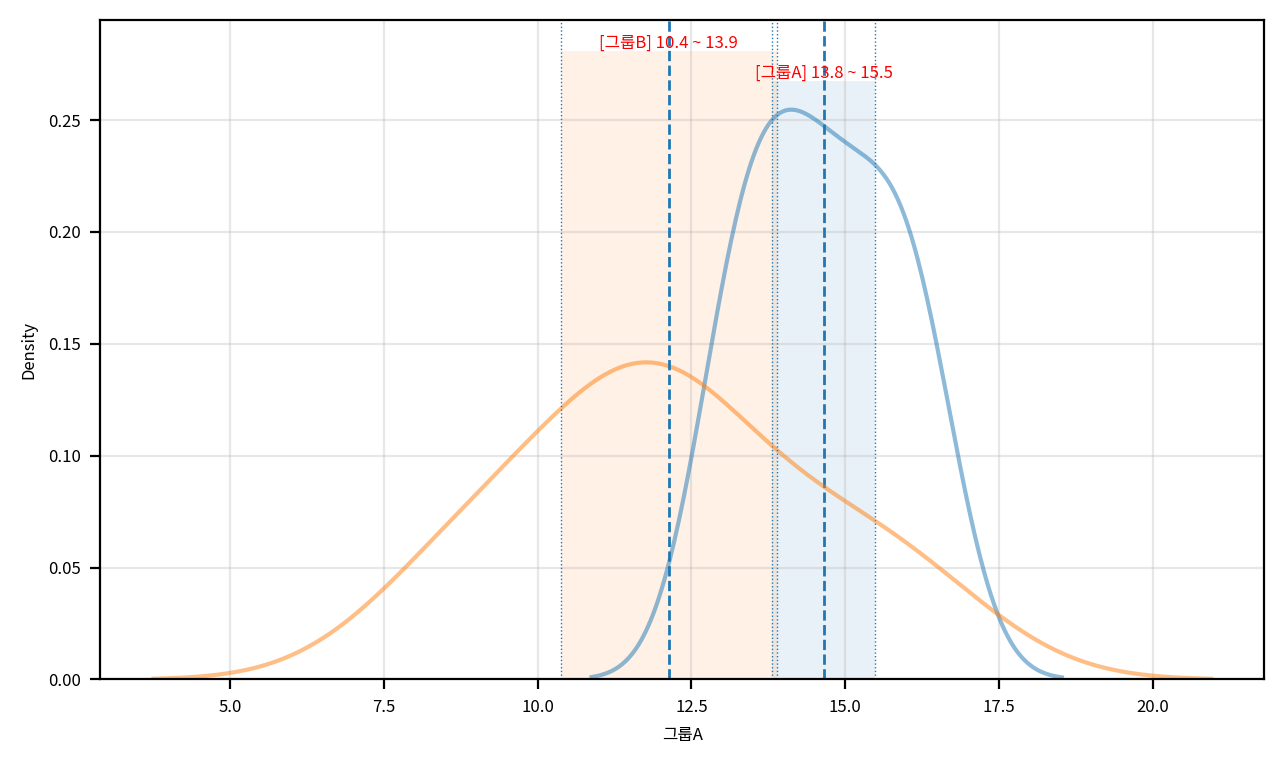

각 그룹의 커널 밀도 함수 그래프의 모양이 정규분포를 띄고 잇으며, 각 그룹의 데이터 분포가 서로 다르다고 할 수 있다.
또한 각 그룹 모두 표본 평균이 신뢰구간에 포함되어 있으므로 데이터가 정상범위에 있다고 할 수 있다.


In [19]:
# 확인할 데이터
data=origin[['그룹A','그룹B']]

width_px=1280
height_px=760
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

mean_check=True

for c in data.columns:
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    # 신뢰구간
    max=data[c].max()
    clevel=0.95
    dof=len(data[c])-1
    sp_mean=data[c].mean()
    sp_std=data[c].std(ddof=1)
    sp_std_error=sp_std/sqrt(len(data[c]))
    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)

    # 평균 표시
    ymin, ymax=ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기
    ax.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s='[%s] %0.1f ~ %0.1f'%(c, cmin, cmax),
            horizontalalignment='center',
            verticalalignment='bottom',
            fontdict={'size':6, 'color':'red'})
    
    mean_check=mean_check and (sp_mean>cmin) and (sp_mean<cmax)

ax.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('myplot.png',dpi=my_dpi)
plt.show()
plt.close()

print('각 그룹의 커널 밀도 함수 그래프의 모양이 정규분포를 띄고 잇으며, 각 그룹의 데이터 분포가 서로 다르다고 할 수 있다.')
print('또한 각 그룹 모두 표본 평균이 신뢰구간에 포함되어 있으므로 데이터가 정상범위에 있다고 할 수 있다.') if mean_check else print('하지만 표본 평균이 신뢰구간에 포함되어 있지 않은 그룹이 있기에, 데이터가 정상범위에 있지 않다고 할 수 있다.')

In [31]:
data=origin[['그룹A','그룹B']]

equal_var_fields=[]
normal_dist=True
report=[]

for c in data.columns:
    s, p=normaltest(data[c])

    normalize=(p>0.05)
    report.append({
        'field':c,
        'statistic':s,
        'p-value':p,
        'result':normalize
    })
    normal_dist=normal_dist and normalize

if len(data.columns)>1:
    if normal_dist:
        n='Bartlett'
        s, p=bartlett(*data.values.T)
        homos=(p>0.05)
        if homos:
            print('== 이 데이터는 정규성과 등분산성을 모두 만족한다. ==')
        else:
            print('== 이 데이터는 정규성은 만족하지만, 등분산성을 만족하지 못한다 ==')
    else:
        n='Levene'
        s, p=levene(*data.values.T, center='median')
        homos=(p>0.05)
        if homos:
            print('== 이 데이터는 정규성은 만족하지 못하지만, 등분산성은 만족한다. ==')
        else:
            print('== 이 데이터는 정규성과 등분산성을 모두 만족하지 못한다. ==')

    report.append({
        'field':n,
        'statistic':s,
        'p-value':p,
        'result':p>0.05
    })

report_df=DataFrame(report).set_index('field')
report_df

== 이 데이터는 정규성은 만족하지만, 등분산성을 만족하지 못한다 ==


,statistic,p-value,result
field,,,
그룹A,1.803522,0.405854,True
그룹B,0.151115,0.927227,True
Bartlett,4.272571,0.038732,False


In [34]:
# 검정할 데이터 필드명
fields=['그룹A','그룹B']

# 로그 적용 여부
use_log=False

# 독립 여부
independency=False

# 검정할 데이터
df=origin[fields]

# 검사할 알고리즘
alternative=['two-sided', 'less', 'greater']

# 결과를 저장할 빈 리스트
result=[]

# 가설식 템플릿
fmt='μ({f0}) {0} μ({f1})'

# 등분산성 충족 여부
equal_var=True

for a in alternative:
    if use_log:
        input1=np.log(df[fields[0]])
        input2=np.log(df[fields[1]])
    else:
        input1=df[fields[0]]
        input2=df[fields[1]]
    if independency:
        s, p=ttest_ind(input1, input2, alternative=a, equal_var=homos)
    else:
        if homos:
            s, p=ttest_rel(input1, input2, alternative=a)
        else:
            s, p=mannwhitneyu(input1, input2, alternative=a)

    itp=None

    if a=='two-sided':
        itp=fmt.format('==' if p>0.05 else '≠', f0=fields[0], f1=fields[1])
        print('차이값에 대한 t 통계량의 값이 %.3f이고 이에 대응되는 유의확률이 %.3f이므로 (p<=0.05)'%(s,p), '귀무가설을 기각하고 대립가설을 채택한다.' if p<0.05 else '대립가설을 기각하고 귀무가설을 채택한다.')
    if a=='less':
        itp=fmt.format('>=' if p>0.05 else '<', f0=fields[0], f1=fields[1])
    if a=='greater':
        itp=fmt.format('<=' if p>0.05 else '>', f0=fields[0], f1=fields[1])

    result.append({
        'alternative':a,
        'statistic':s,
        'p-value':p,
        'H0':p>0.05,
        'H1':p<=0.05,
        'interpretation':itp
    })

    if a=='two-sided' and p>0.05:
        break

rdf=DataFrame(result)
rdf.set_index('alternative', inplace=True)
rdf

차이값에 대한 t 통계량의 값이 81.000이고 이에 대응되는 유의확률이 0.021이므로 (p<=0.05) 귀무가설을 기각하고 대립가설을 채택한다.


,statistic,p-value,H0,H1,interpretation
alternative,,,,,
two-sided,81.0,0.020989,False,True,μ(그룹A) ≠ μ(그룹B)
less,81.0,0.991434,True,False,μ(그룹A) >= μ(그룹B)
greater,81.0,0.010494,False,True,μ(그룹A) > μ(그룹B)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

그룹A vs. 그룹B: Mann-Whitney-Wilcoxon test greater, P_val:1.049e-02 U_stat=8.100e+01


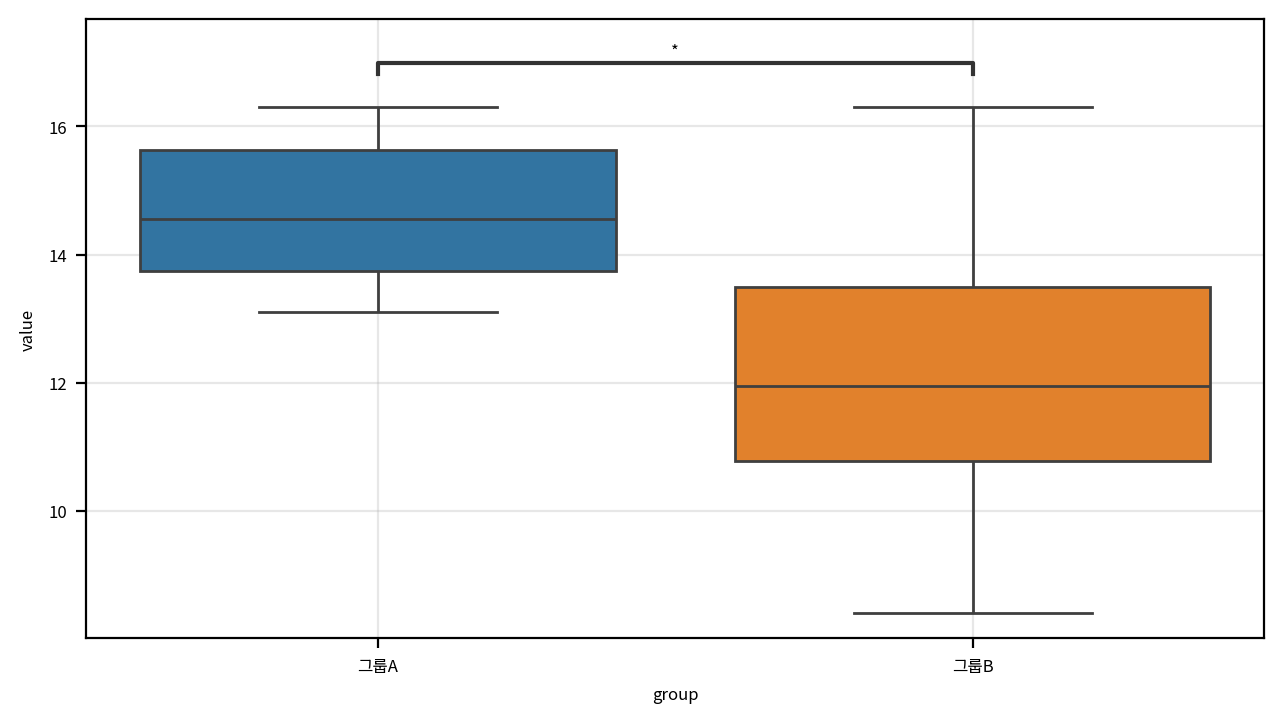

In [15]:
# 검정할 데이터 필드명
fields=['그룹A','그룹B']

# 검정 방법
# 't-test_ind', 't-test_paired', 't-test_welch', 'Mann-Whitney', 'Mann-Whitney-gt', 'Mann-Whitney-ls', 'Levene', 'Wilcoxon', 'Kruskal'
test_method='Mann-Whitney-gt'

# 데이터 재배치
df=melt(origin[fields], value_vars=fields, var_name='group', value_name='value')

# 1. 그래프 초기화
width_px=1280
height_px=720
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2. 그래프 그리기
sb.boxplot(data=df, x='group', y='value', hue='group')
annotator=Annotator(ax, data=df, x='group', y='value', pairs=[fields])
annotator.configure(test=test_method)
annotator.apply_and_annotate()

# 3. 그래프 꾸미기
ax.grid(True, alpha=0.3)

# 4. 출력
plt.tight_layout()
# plt.savefig('myplot.png',dpi=my_dpi)
plt.show()
plt.close()